# Time Series Simulation from an Amplitude Spectral Density

In this tutorial, we will demonstrate the time series simulation of an amplitude spectral density (ASD)
using the function ``kontrol.spectral.asd2ts()``.

For the ASD, we will use the ASD of a colored noise.
The "coloring" was done by passing the white noise through an IIR filter.

\begin{equation}
    H(s) = \frac{(s+1)^2}{s^2(s+10)}\,.
\end{equation}

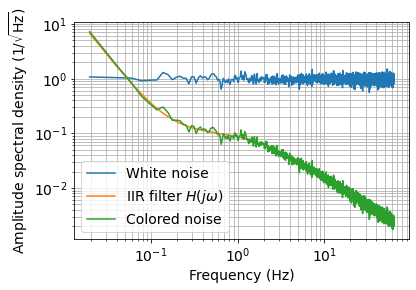

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal


fs = 128  # Sampling frequency (Hz)
t_final = 512  # Final time (s)
t = np.arange(0, t_final, 1/fs)
np.random.seed(123)
white_noise = np.random.normal(loc=0, scale=1*np.sqrt(fs/2), size=len(t))

s = control.tf("s")
color = (s+1)**2 / (s**2 * (s+10))

averages = 10
window = np.hanning(int(len(white_noise)/averages))
f, white_noise_psd = scipy.signal.welch(white_noise, fs=fs, window=window)
white_noise_psd = white_noise_psd[f>0]
f = f[f>0]
white_noise_asd = white_noise_psd**0.5
colored_noise_asd = abs(color(1j*2*np.pi*f)) * white_noise_asd
# Alternatively, use control.forced_response
# t, colored_noise= control.forced_response(color, U=white_noise, T=t)
# _, colored_noise_psd = scipy.signal.welch(colored_noise, fs=fs, window=np.hanning(int(len(white_noise)/10)))

plt.rcParams["font.size"] = 14
plt.figure(figsize=(6, 4))
plt.loglog(f, white_noise_psd**0.5, label="White noise")
plt.loglog(f, abs(color(1j*2*np.pi*f)), label="IIR filter $H(j\omega)$")
plt.loglog(f, colored_noise_asd, label="Colored noise")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude spectral density $(1/\sqrt{\mathrm{Hz}})$")
plt.xlabel("Frequency (Hz)")
plt.show()

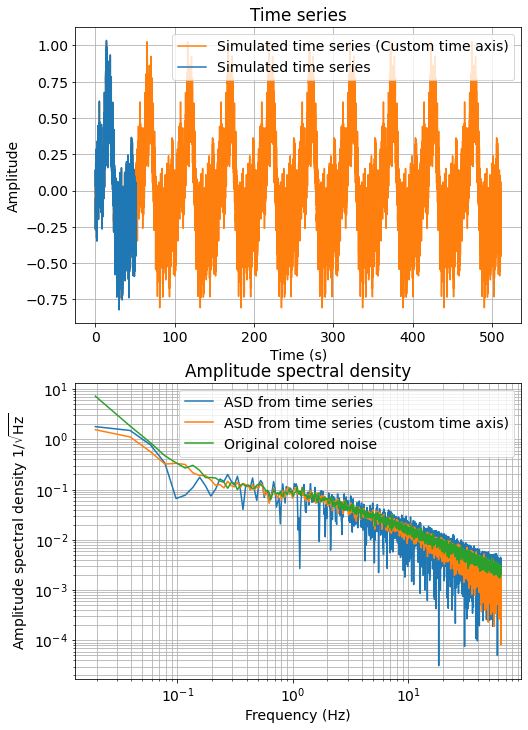

In [2]:
import kontrol


# Default
np.random.seed(123)
t_sim, time_series_sim = kontrol.spectral.asd2ts(colored_noise_asd, f=f)
fs_sim = 1/(t_sim[1]-t_sim[0])

# Use a custom time axis
np.random.seed(123)  # Use a fixed seed so the time series is the same as the previous one
t_new = np.arange(0, t_sim[-1]*10, 1/fs)  # Use ten times the length
t_new, time_series_new = kontrol.spectral.asd2ts(colored_noise_asd, f=f, t=t_new)
fs_new = 1/(t_new[1]-t_new[0])

# Calculated the ASD of the simulated time series
f_sim, psd_sim = scipy.signal.welch(time_series_sim, fs=fs_sim, window=np.hanning(len(t_sim)))
f_new, psd_new = scipy.signal.welch(time_series_new, fs=fs_new, window=np.hanning(len(t_sim)))

psd_sim = psd_sim[f_sim>0]
psd_new = psd_new[f_new>0]
f_sim = f_sim[f_sim>0]
f_new = f_new[f_new>0]
asd_sim = psd_sim**0.5
asd_new = psd_new**0.5

plt.figure(figsize=(8, 12))
plt.subplot(211)
plt.title("Time series")
plt.plot(t_new, time_series_new, color="C1", label="Simulated time series (Custom time axis)")
plt.plot(t_sim, time_series_sim, color="C0", label="Simulated time series")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")

plt.subplot(212)
plt.title("Amplitude spectral density")
plt.loglog(f_sim, asd_sim, label="ASD from time series")
plt.loglog(f_new, asd_new, label="ASD from time series (custom time axis)")
plt.loglog(f, colored_noise_asd, label="Original colored noise")
# Note that the second one is less noisy because of Welch averaging.

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude spectral density $1/\sqrt{\rm{Hz}}$")
plt.xlabel("Frequency (Hz)")
plt.show()